In [2]:
import json
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
baselines = pd.DataFrame(
    {
        "method": [
            "Pretrained",
            # "Individuals",
            "Simple Average",
            "Task Arithmetic",
            "Ties-Merging",
            "Fisher Merging",
            "RegMean",
            "Layer-Wise AdaMerging",
            "Weight-Ensembling MoE",
        ],
        "average": [
            48.2,
            # 90.3,
            66.5,
            68.0,
            72.2,
            70.6,
            80.5,
            82.6,
            89.2,
        ],
        "num_params": [
            87456000,
            # 87456000,
            87456000,
            87456000,
            87456000,
            87456000,
            87456000,
            87456000,
            547.97 * 1000_000,
        ],
    }
)
display(baselines)

,method,average,num_params
0,Pretrained,48.2,87456000.0
1,Simple Average,66.5,87456000.0
2,Task Arithmetic,68.0,87456000.0
3,Ties-Merging,72.2,87456000.0
4,Fisher Merging,70.6,87456000.0
5,RegMean,80.5,87456000.0
6,Layer-Wise AdaMerging,82.6,87456000.0
7,Weight-Ensembling MoE,89.2,547970000.0


In [4]:
data_dir = "/workspace/svd_subspace/outputs/ViT-B-32/eight_tasks"
moe_data = defaultdict(list)
for gate_k in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 768, 1024]:
    for k in [4, 8, 16, 32, 64, 128, -1]:
        file_name = f"gate_k={gate_k}_k={k}.json"
        file_name = os.path.join(data_dir, file_name)
        if not os.path.exists(file_name):
            # print(f"File {file_name} does not exist")
            continue
        with open(file_name) as f:
            data = json.load(f)
        moe_data["num_params"].append(data["model_info"]["all_params"])
        moe_data["gate_k"].append(gate_k)
        moe_data["k"].append(k)
        accuracies = {}
        for key in data:
            if key == "model_info":
                continue
            accuracies[key] = data[key]["accuracy"]
        average_accuracy = np.mean(list(accuracies.values())) * 100
        for key in accuracies:
            moe_data[key].append(accuracies[key])
        moe_data["average"].append(average_accuracy)
moe_data = pd.DataFrame(moe_data)

# 使用 Styler 对象并应用背景颜色渐变
styled_df = moe_data.style.background_gradient(cmap="RdYlGn")

# 显示结果
styled_df

,num_params,gate_k,k,svhn,stanford_cars,resisc45,eurosat,gtsrb,mnist,dtd,sun397,average
0,94008576,1,4,0.901621,0.623057,0.716667,0.836667,0.748298,0.971300,0.602128,0.667758,75.843684
1,99316992,1,8,0.935502,0.656510,0.759206,0.886296,0.827553,0.986900,0.663298,0.680403,79.945873
2,109933824,1,16,0.953442,0.688720,0.802698,0.910741,0.867300,0.991500,0.711702,0.691889,82.724909
3,131167488,1,32,0.959473,0.717572,0.833175,0.925926,0.895962,0.993000,0.744681,0.705844,84.695406
4,173634816,1,64,0.962200,0.737470,0.852381,0.930741,0.908789,0.993600,0.756383,0.716826,85.729878
5,258569472,1,128,0.962853,0.749534,0.856032,0.931111,0.912272,0.994400,0.763830,0.725491,86.194041
6,768177408,1,-1,0.963122,0.759980,0.859841,0.928889,0.914885,0.994300,0.767021,0.733199,86.515477
7,94672128,2,4,0.898471,0.632384,0.733175,0.890741,0.831987,0.975800,0.614894,0.669320,78.084642
8,99980544,2,8,0.934773,0.664097,0.779841,0.914815,0.905463,0.989400,0.685106,0.678690,81.902312
9,110597376,2,16,0.951982,0.700659,0.822222,0.937407,0.942359,0.992700,0.729255,0.693300,84.623569


/tmp/ipykernel_1143/3036371907.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Dense' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_data.loc[plot_data["k"] == -1, "k"] = "Dense"
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


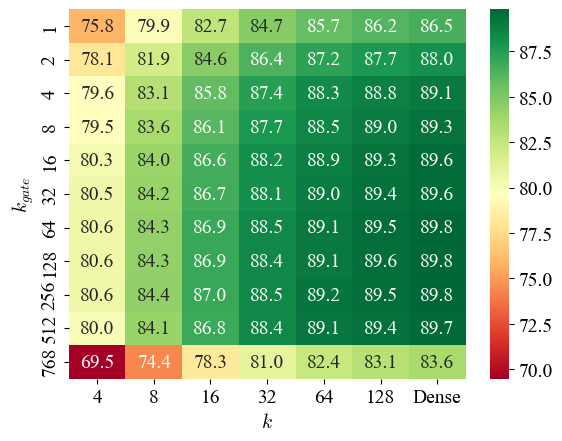

/tmp/ipykernel_1143/3036371907.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Dense' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_data.loc[plot_data["k"] == -1, "k"] = "Dense"
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


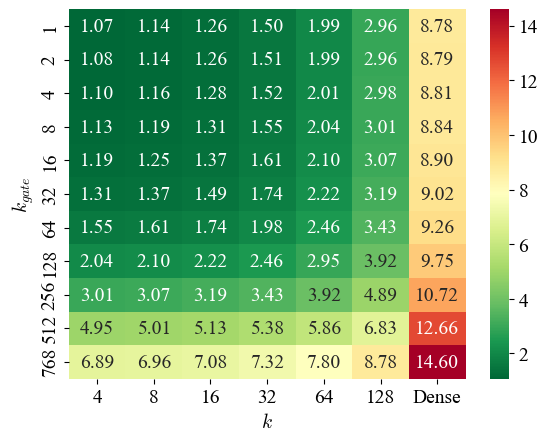

In [73]:
matplotlib.rcParams["font.size"] = 14

plot_data = moe_data.copy()
plot_data["method"] = "Ours"
plot_data.loc[plot_data["k"] == -1, "k"] = "Dense"
pivot_data = (
    plot_data[["gate_k", "k", "average"]]
    .pivot(index="gate_k", columns="k", values="average")
    .copy()
)

sns.heatmap(data=pivot_data, annot=True, fmt=".1f", cmap="RdYlGn")
plt.xlabel("$k$")
plt.ylabel("$k_{gate}$")
plt.savefig("clip-vit-b-32_hp-acc.pdf", bbox_inches="tight")
plt.show()

plot_data = moe_data.copy()
plot_data["method"] = "Ours"
plot_data.loc[plot_data["k"] == -1, "k"] = "Dense"
plot_data["num_params"] = plot_data["num_params"] / 87456000
pivot_data = (
    plot_data[["gate_k", "k", "num_params"]]
    .pivot(index="gate_k", columns="k", values="num_params")
    .copy()
)

sns.heatmap(data=pivot_data, annot=True, fmt=".2f", cmap="RdYlGn_r")
plt.xlabel("$k$")
plt.ylabel("$k_{gate}$")
plt.savefig("clip-vit-b-32_hp-params.pdf", bbox_inches="tight")
plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


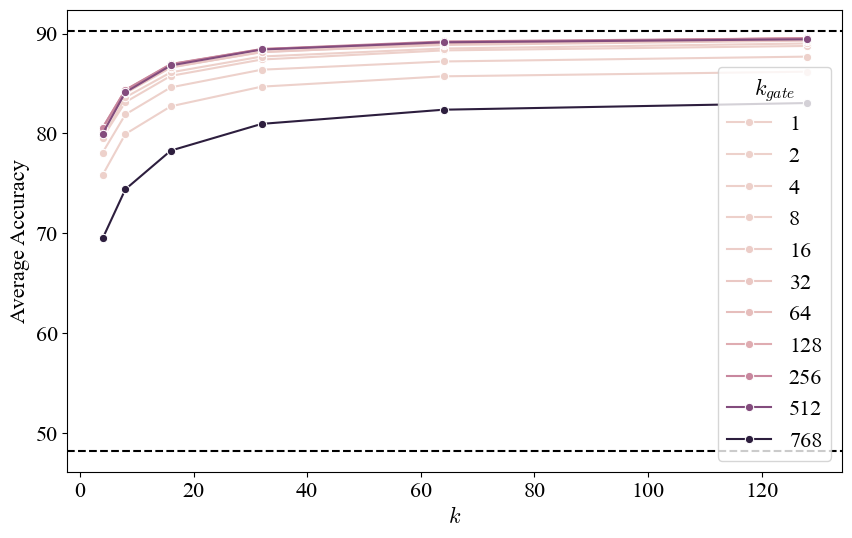

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


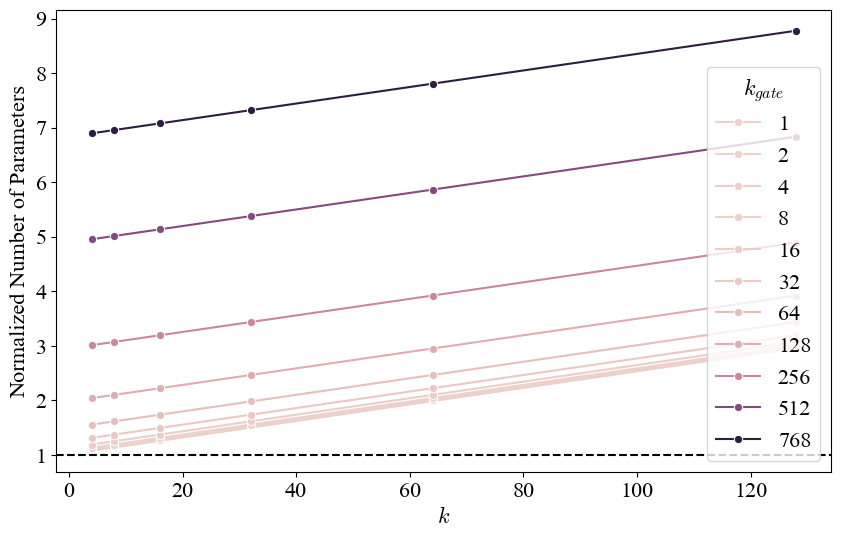

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set font size
matplotlib.rcParams["font.size"] = 16

plot_data = moe_data.copy()
# Replace k = -1 with infinity
plot_data["k"] = plot_data["k"].replace(-1, np.inf)
plot_data["num_params"] = plot_data["num_params"] / 87456000

# Plot line plot for accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_data,
    x="k",
    y="average",
    hue="gate_k",
    marker="o",
    legend="full",
)
# plot the baseline of individual models 90.3
plt.axhline(y=90.3, color="k", linestyle="--")
plt.axhline(y=48.2, color="k", linestyle="--")

plt.xlabel("$k$")
plt.ylabel("Average Accuracy")
plt.legend(title="$k_{gate}$", loc="lower right")
plt.savefig("clip-vit-b-32_line-acc.pdf", bbox_inches="tight")
plt.show()

# Plot line plot for number of parameters
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_data,
    x="k",
    y="num_params",
    hue="gate_k",
    marker="o",
    legend="full",
)
plt.xlabel("$k$")
plt.ylabel("Normalized Number of Parameters")
plt.axhline(y=1, color="k", linestyle="--")

plt.legend(title="$k_{gate}$", loc="lower right")
plt.savefig("clip-vit-b-32_line-params.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_281910/1065793999.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Dense' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  plot_data.loc[plot_data["k"] == -1, "k"] = "Dense"


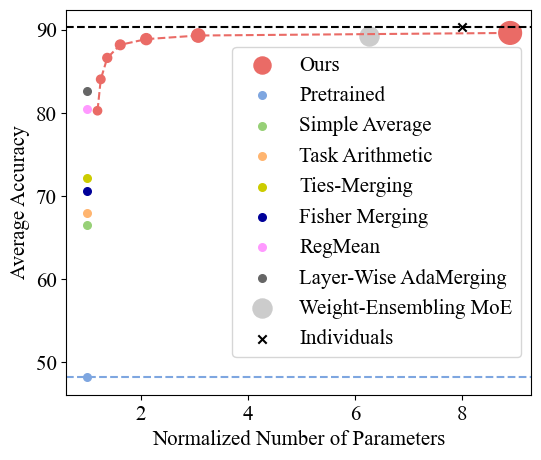

In [53]:
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

matplotlib.rcParams["font.size"] = 15

colors = [
    "#EA6B66",
    "#7EA6E0",
    "#97D077",
    "#FFB570",
    "#CCCC00",
    "#000099",
    "#FF99FF",
    "#666666",
    "#CCCCCC",
]
plot_data = moe_data[moe_data["gate_k"] == 16].copy()
plot_data["method"] = "Ours"
plot_data.loc[plot_data["k"] == -1, "k"] = "Dense"
plot_data

fig, ax = plt.subplots(figsize=(6, 5))
# ours
ours_scatter = plt.scatter(
    plot_data["num_params"] / 87456000,
    plot_data["average"],
    s=plot_data["num_params"] / 87456000 * 30,
    marker="o",  # Marker for "Ours"
    c=colors[0],
    label="Ours",
)
plt.plot(
    plot_data["num_params"] / 87456000,
    plot_data["average"],
    c=colors[0],
    # dashed
    linestyle="--",
)

# baselines
baseline_scatters = []
for i in range(len(baselines["method"])):
    scatter = plt.scatter(
        baselines["num_params"][i] / 87456000,
        baselines["average"][i],
        label=baselines["method"][i],
        s=baselines["num_params"][i] / 87456000 * 30,
        c=colors[(i + 1)],  # Cycle through colors
    )
    baseline_scatters.append(scatter)

# plot the average accuracy of individuals as a horizontal line
plt.axhline(y=90.3, color="k", linestyle="--")
plt.scatter([8], [90.3], color="k", marker="x", label="Individuals")
plt.axhline(y=48.2, color=colors[1], linestyle="--")

plt.xlabel("Normalized Number of Parameters")
plt.ylabel("Average Accuracy")
plt.legend()

plt.savefig("clip-vit-b-32_scatter.pdf", bbox_inches="tight")
plt.show()